1. Собрать класс датасет с функциями из ноутбука по генерации датасета. Надо функции перенести в класс + добавить возможность при инициализации менять длину последовательности кадров.
2. Построить график зависимости от количества кадров в последовательности (уменьшать и увеличивать)
3. Построить график зависимости от количества модулей лстм.

In [1]:
# !pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [49]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os

from torch import optim
import time
import math

from mpl_toolkits.mplot3d import Axes3D  
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation
from time import sleep

use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

%matplotlib notebook

cpu


In [157]:
training_subjects = list(range(0, 28)) #количество людей выполняющих действия
training_classes = [8, 10, 22, 23, 27] #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
training_cameras = [1, 2, 3] 

max_body_true = 1
max_body_kinect = 1

num_joint = 25
max_frame = 300

In [158]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [159]:
class Test_Dataset(Dataset):
    def __init__(self):
        self.samples = list(range(0, 100)) ##генерируем случайные данные
        # Все подготовления данных происходят в инициализации:
        # - разделение данных на train/test/ validate
        # - аугментация (трансформация) данных 
        # - чтние аннотаций
        # - считывание по индексу
         # - Применяет выбранные трансформации к данным

    def __len__(self):
        # # Возвращает данные и лейблы
       
        # - отправление данных на гпу
        # - лучше возвращать данные как тензор или словарь
         # - Применяет выбранные трансформации к данным
        return len(self.samples) #возвращаем данные

    def __getitem__(self, idx):
        return (self.samples[idx], label) 
    

In [160]:
class Skeleton_Dataset(Dataset):
        
    def __init__(self, data_path, broken_files_path, chonk_len=45, transform=None):
        
        self.chonk_len = chonk_len
        working_files_with_labels, action_classes = self.read_data(data_path, broken_files_path)
        
        self.data_path = data_path
        self.data = self.generate_data(working_files_with_labels)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]
        
        

    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.chonk_len,75)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
        return (item, label) 
    
    
    def read_data(self, data_path, broken_files_path):
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}

        with open(broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in training_classes and camera_id in training_cameras:  #and subject_id in training_subjects:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename,action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter+=1
                        files.append([filename,action_classes[action_class]])
    #                     labels.append([action_class])
        print("action classes: ", action_classes)
        print("action files: ", files_counter)

        return files, action_classes
    
    def get_nonzero_std(self, s): 
        index = s.sum(-1).sum(-1) != 0  
        s = s[index]
        if len(s) != 0:
            s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
        else:
            s = 0
        return s

    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence

    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data

    def create_coords_blocks(self, test_file, chonk_len):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(self.data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = chonk_len * int(len(test_frames)/chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []


        return blocks, new_labels
    
    def generate_data(self, working_files_with_labels):
        data = []
        labels = []
        ##########################################################################
        numbers = {0: 8, 1: 10, 2: 21, 3: 22, 4: 23, 5: 27} #####
        ##################################################################
        for file in working_files_with_labels:
            frames_blocks, label = self.create_coords_blocks(file, self.chonk_len)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] = numbers[label[0]] + len(label)
                data = data + frames_blocks
                labels = labels + label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
               
        return test_data

In [161]:
dataset30 = Skeleton_Dataset(data_path="./nturgb+d_skeletons/", 
                           broken_files_path="./NTU_RGBD_samples_with_missing_skeletons.txt",
                           chonk_len = 30
                           )

dataset30.data.to_csv("skeletons_30_frames.csv", index = False)

action classes:  {8: 0, 10: 1, 22: 2, 23: 3, 27: 4}
action files:  {8: 120, 10: 120, 22: 120, 23: 120, 27: 120}


In [162]:
dataset40 = Skeleton_Dataset(data_path="./nturgb+d_skeletons/", 
                           broken_files_path="./NTU_RGBD_samples_with_missing_skeletons.txt",
                           chonk_len = 40
                           )

dataset40.data.to_csv("skeletons_40_frames.csv", index = False)

action classes:  {8: 0, 10: 1, 22: 2, 23: 3, 27: 4}
action files:  {8: 120, 10: 120, 22: 120, 23: 120, 27: 120}


In [163]:
dataset50 = Skeleton_Dataset(data_path="./nturgb+d_skeletons/", 
                           broken_files_path="./NTU_RGBD_samples_with_missing_skeletons.txt",
                           chonk_len = 50
                           )

dataset50.data.to_csv("skeletons_50_frames.csv", index = False)

action classes:  {8: 0, 10: 1, 22: 2, 23: 3, 27: 4}
action files:  {8: 120, 10: 120, 22: 120, 23: 120, 27: 120}


In [164]:
dataset60 = Skeleton_Dataset(data_path="./nturgb+d_skeletons/", 
                           broken_files_path="./NTU_RGBD_samples_with_missing_skeletons.txt",
                           chonk_len = 60
                           )

dataset60.data.to_csv("skeletons_60_frames.csv", index = False)

action classes:  {8: 0, 10: 1, 22: 2, 23: 3, 27: 4}
action files:  {8: 120, 10: 120, 22: 120, 23: 120, 27: 120}


In [165]:
dataset70 = Skeleton_Dataset(data_path="./nturgb+d_skeletons/", 
                           broken_files_path="./NTU_RGBD_samples_with_missing_skeletons.txt",
                           chonk_len = 70
                           )

dataset70.data.to_csv("skeletons_70_frames.csv", index = False)

action classes:  {8: 0, 10: 1, 22: 2, 23: 3, 27: 4}
action files:  {8: 120, 10: 120, 22: 120, 23: 120, 27: 120}


In [166]:
dataset70.data.head()

,0,1,2,3,4,5,6,7,8,9,...,5241,5242,5243,5244,5245,5246,5247,5248,5249,labels
0,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,...,-0.027093,-0.042608,3.824710,0.048732,-0.219962,3.671710,0.046590,-0.117605,3.680466,0
1,0.399282,-0.026338,4.099298,0.382165,0.177244,4.002089,0.359935,0.376536,3.893836,0.338453,...,0.660827,0.287256,4.129000,0.675887,0.616361,4.131474,0.676725,0.590385,4.115742,2
2,0.284738,0.178680,3.764987,0.299845,0.428857,3.687624,0.314031,0.673921,3.600093,0.296217,...,-0.034679,1.041079,3.375000,0.315725,1.058225,3.260713,0.307840,1.020900,3.246750,4
3,0.259082,0.107407,3.673126,0.252590,0.379644,3.586978,0.246256,0.646283,3.491236,0.249200,...,0.172262,0.018709,3.608600,0.184085,-0.118795,3.782616,0.191225,-0.097937,3.771302,0
4,0.161285,0.164668,3.766516,0.163123,0.415820,3.683940,0.164665,0.662383,3.591946,0.180526,...,0.183399,0.949272,3.116572,0.355378,1.074895,3.255241,0.371325,1.014023,3.255833,2


In [68]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [69]:
len(dataset), [int(np.around(0.75*len(dataset))),int(np.around(0.25*len(dataset)))]

(429, [322, 107])

In [168]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping"}

#### 30 кадров

In [179]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset30, [int(np.around(0.75*len(dataset30))),int(np.around(0.25*len(dataset30)))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_30 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_30.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.6171  / cheer up ✗ (clapping)
epoch : 15 iter : 20 (0m 35s) 1.5743  / cheer up ✗ (clapping)
epoch : 31 iter : 8 (1m 9s) 1.3995  / hand waving ✓
epoch : 46 iter : 28 (1m 43s) 1.0789  / cheer up ✓
epoch : 62 iter : 16 (2m 17s) 1.0972  / cheer up ✗ (clapping)
epoch : 78 iter : 4 (2m 51s) 0.9822  / cheer up ✓
epoch : 93 iter : 24 (3m 25s) 1.1438  / clapping ✓
epoch : 109 iter : 12 (4m 0s) 0.8501  / clapping ✓
epoch : 125 iter : 0 (4m 34s) 0.7392  / hand waving ✓
epoch : 140 iter : 20 (5m 8s) 0.9663  / cheer up ✓
epoch : 156 iter : 8 (5m 43s) 0.4821  / sitting down ✗ (jump up)
epoch : 171 iter : 28 (6m 18s) 0.6195  / clapping ✓
epoch : 187 iter : 16 (6m 53s) 0.3613  / clapping ✓
epoch : 203 iter : 4 (7m 28s) 0.7033  / jump up ✓
epoch : 218 iter : 24 (8m 3s) 0.3802  / sitting down ✓
epoch : 234 iter : 12 (8m 37s) 0.5992  / jump up ✓
epoch : 250 iter : 0 (9m 11s) 0.4195  / sitting down ✓
epoch : 265 iter : 20 (9m 45s) 0.6811  / sitting down ✓
epoch : 281 iter : 8 

#### 40 кадров

In [180]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset40, [int(np.around(0.75*len(dataset40))),int(np.around(0.25*len(dataset40)))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_40 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_40.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.6580  / jump up ✓
epoch : 15 iter : 20 (0m 45s) 1.5408  / cheer up ✗ (clapping)
epoch : 31 iter : 8 (1m 30s) 1.2747  / hand waving ✗ (jump up)
epoch : 46 iter : 28 (2m 15s) 1.2964  / cheer up ✓
epoch : 62 iter : 16 (3m 0s) 0.8114  / hand waving ✗ (clapping)
epoch : 78 iter : 4 (3m 45s) 0.4506  / clapping ✓
epoch : 93 iter : 24 (4m 30s) 0.3038  / jump up ✓
epoch : 109 iter : 12 (5m 16s) 0.9161  / jump up ✗ (sitting down)
epoch : 125 iter : 0 (6m 1s) 0.1439  / sitting down ✓
epoch : 140 iter : 20 (6m 46s) 0.3941  / jump up ✓
epoch : 156 iter : 8 (7m 31s) 0.0612  / jump up ✓
epoch : 171 iter : 28 (8m 17s) 0.1086  / cheer up ✓
epoch : 187 iter : 16 (9m 1s) 0.1615  / cheer up ✓
epoch : 203 iter : 4 (9m 47s) 0.3221  / hand waving ✓
epoch : 218 iter : 24 (10m 31s) 0.6094  / hand waving ✓
epoch : 234 iter : 12 (11m 16s) 0.1621  / jump up ✓
epoch : 250 iter : 0 (12m 1s) 0.3975  / jump up ✓
epoch : 265 iter : 20 (12m 46s) 0.1113  / clapping ✓
epoch : 281 iter : 8 (13

#### 50 кадров

In [181]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset50, [int(np.around(0.75*len(dataset50))),int(np.around(0.25*len(dataset50)))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_50 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_50.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.6168  / cheer up ✓
epoch : 17 iter : 7 (0m 55s) 1.5916  / cheer up ✗ (sitting down)
epoch : 34 iter : 14 (1m 51s) 1.3346  / hand waving ✗ (clapping)
epoch : 51 iter : 21 (2m 46s) 1.1365  / cheer up ✓
epoch : 68 iter : 28 (3m 42s) 0.6832  / clapping ✓
epoch : 86 iter : 6 (4m 37s) 0.7241  / hand waving ✓
epoch : 103 iter : 13 (5m 33s) 0.4796  / cheer up ✓
epoch : 120 iter : 20 (6m 28s) 0.2420  / clapping ✓
epoch : 137 iter : 27 (7m 24s) 0.4591  / clapping ✓
epoch : 155 iter : 5 (8m 19s) 0.2607  / hand waving ✓
epoch : 172 iter : 12 (9m 15s) 0.0930  / cheer up ✓
epoch : 189 iter : 19 (10m 10s) 0.0364  / jump up ✓
epoch : 206 iter : 26 (11m 6s) 0.5056  / cheer up ✓
epoch : 224 iter : 4 (12m 1s) 0.2173  / cheer up ✓
epoch : 241 iter : 11 (12m 58s) 0.1401  / jump up ✓
epoch : 258 iter : 18 (13m 53s) 0.0276  / jump up ✓
epoch : 275 iter : 25 (14m 49s) 0.1082  / hand waving ✓
epoch : 293 iter : 3 (15m 44s) 0.0088  / sitting down ✓
epoch : 310 iter : 10 (16m 40s) 0.

#### 60 кадров

In [182]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset60, [int(np.around(0.75*len(dataset60))),int(np.around(0.25*len(dataset60)))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_60 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_60.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.5800  / clapping ✓
epoch : 20 iter : 0 (1m 5s) 1.4721  / hand waving ✓
epoch : 40 iter : 0 (2m 10s) 1.2386  / cheer up ✓
epoch : 60 iter : 0 (3m 16s) 0.9810  / cheer up ✓
epoch : 80 iter : 0 (4m 21s) 1.1656  / cheer up ✓
epoch : 100 iter : 0 (5m 27s) 0.6704  / cheer up ✓
epoch : 120 iter : 0 (6m 32s) 1.3326  / sitting down ✗ (jump up)
epoch : 140 iter : 0 (7m 37s) 0.2087  / clapping ✓
epoch : 160 iter : 0 (8m 43s) 1.0833  / jump up ✓
epoch : 180 iter : 0 (9m 48s) 0.1815  / clapping ✗ (cheer up)
epoch : 200 iter : 0 (10m 54s) 0.1716  / cheer up ✓
epoch : 220 iter : 0 (11m 59s) 0.6055  / jump up ✓
epoch : 240 iter : 0 (13m 5s) 0.3830  / hand waving ✓
epoch : 260 iter : 0 (14m 10s) 0.3439  / sitting down ✓
epoch : 280 iter : 0 (15m 16s) 0.8644  / cheer up ✓
epoch : 300 iter : 0 (16m 22s) 0.8249  / sitting down ✗ (hand waving)
epoch : 320 iter : 0 (17m 28s) 0.3397  / cheer up ✓
epoch : 340 iter : 0 (18m 33s) 0.2107  / clapping ✓
epoch : 360 iter : 0 (19m 39s) 0

#### 70 кадров

In [183]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset70, [int(np.around(0.75*len(dataset70))),int(np.around(0.25*len(dataset70)))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_70 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_70.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.5910  / cheer up ✓
epoch : 31 iter : 4 (1m 14s) 1.5055  / hand waving ✗ (sitting down)
epoch : 62 iter : 8 (2m 28s) 1.0823  / hand waving ✗ (sitting down)
epoch : 93 iter : 12 (3m 42s) 1.3724  / jump up ✗ (clapping)
epoch : 125 iter : 0 (4m 56s) 1.0937  / sitting down ✓
epoch : 156 iter : 4 (6m 10s) 1.2284  / cheer up ✗ (sitting down)
epoch : 187 iter : 8 (7m 24s) 0.8479  / hand waving ✓
epoch : 218 iter : 12 (8m 37s) 0.3108  / clapping ✓
epoch : 250 iter : 0 (9m 50s) 1.4957  / cheer up ✗ (jump up)
epoch : 281 iter : 4 (11m 5s) 0.2923  / jump up ✓
epoch : 312 iter : 8 (12m 20s) 0.4754  / clapping ✓
epoch : 343 iter : 12 (13m 34s) 0.3622  / jump up ✗ (clapping)
epoch : 375 iter : 0 (14m 48s) 1.3517  / jump up ✓
epoch : 406 iter : 4 (16m 3s) 0.6755  / sitting down ✓
epoch : 437 iter : 8 (17m 18s) 0.8520  / hand waving ✓
epoch : 468 iter : 12 (18m 31s) 0.4836  / sitting down ✓
epoch : 500 iter : 0 (19m 45s) 0.6022  / hand waving ✓
epoch : 531 iter : 4 (20m 59s

#### Сравнение результатов

<IPython.core.display.Javascript object>


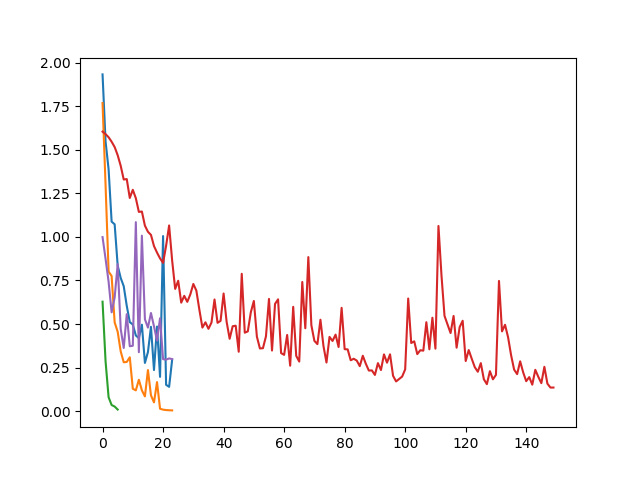

In [187]:
plt.plot(list(range(0,len(all_losses_30))),all_losses_30)
plt.plot(list(range(0,len(all_losses_40))),all_losses_40)
plt.plot(list(range(0,len(all_losses_50))),all_losses_50)
plt.plot(list(range(0,len(all_losses_60))),all_losses_60)
plt.plot(list(range(0,len(all_losses_70))),all_losses_70)
plt.show()

#### Запуск с 1 модулем

In [188]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset40, [int(np.around(0.75*len(dataset40))),int(np.around(0.25*len(dataset40)))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 1
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_40_1 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_40_1.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.6618  / sitting down ✗ (clapping)
epoch : 15 iter : 20 (0m 31s) 1.4914  / cheer up ✗ (clapping)
epoch : 31 iter : 8 (1m 3s) 0.9395  / jump up ✓
epoch : 46 iter : 28 (1m 34s) 1.1273  / sitting down ✓
epoch : 62 iter : 16 (2m 6s) 0.6453  / sitting down ✓
epoch : 78 iter : 4 (2m 37s) 0.2894  / clapping ✓
epoch : 93 iter : 24 (3m 9s) 0.7033  / clapping ✓
epoch : 109 iter : 12 (3m 40s) 0.4431  / hand waving ✓
epoch : 125 iter : 0 (4m 12s) 0.4464  / sitting down ✓
epoch : 140 iter : 20 (4m 43s) 0.5334  / sitting down ✗ (jump up)
epoch : 156 iter : 8 (5m 15s) 0.4444  / sitting down ✓
epoch : 171 iter : 28 (5m 46s) 0.1981  / jump up ✓
epoch : 187 iter : 16 (6m 18s) 0.6313  / jump up ✗ (clapping)
epoch : 203 iter : 4 (6m 49s) 0.6652  / cheer up ✓
epoch : 218 iter : 24 (7m 21s) 0.3155  / hand waving ✓
epoch : 234 iter : 12 (7m 52s) 0.4021  / clapping ✓
epoch : 250 iter : 0 (8m 24s) 0.7410  / jump up ✗ (cheer up)
epoch : 265 iter : 20 (8m 55s) 0.7356  / cheer up ✓
epo

#### Запуск с 2 модулями

In [189]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset40, [int(np.around(0.75*len(dataset40))),int(np.around(0.25*len(dataset40)))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_40_2 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_40_2.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.6314  / hand waving ✗ (clapping)
epoch : 15 iter : 20 (0m 44s) 1.5976  / jump up ✗ (hand waving)
epoch : 31 iter : 8 (1m 30s) 1.4792  / jump up ✗ (clapping)
epoch : 46 iter : 28 (2m 14s) 1.2727  / cheer up ✓
epoch : 62 iter : 16 (2m 59s) 1.0833  / cheer up ✓
epoch : 78 iter : 4 (3m 44s) 0.7872  / sitting down ✗ (jump up)
epoch : 93 iter : 24 (4m 29s) 0.4965  / jump up ✓
epoch : 109 iter : 12 (5m 14s) 0.5878  / cheer up ✗ (clapping)
epoch : 125 iter : 0 (5m 59s) 0.7917  / clapping ✓
epoch : 140 iter : 20 (6m 44s) 0.3354  / hand waving ✓
epoch : 156 iter : 8 (7m 29s) 0.4007  / jump up ✓
epoch : 171 iter : 28 (8m 14s) 0.6092  / clapping ✓
epoch : 187 iter : 16 (9m 0s) 0.5803  / hand waving ✓
epoch : 203 iter : 4 (9m 46s) 0.2301  / cheer up ✓
epoch : 218 iter : 24 (10m 31s) 0.5759  / jump up ✓
epoch : 234 iter : 12 (11m 16s) 0.3958  / hand waving ✓
epoch : 250 iter : 0 (12m 1s) 0.3946  / hand waving ✓
epoch : 265 iter : 20 (12m 46s) 0.4555  / clapping ✓
epoch :

#### Запуск с 3 модулями

In [190]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset40, [int(np.around(0.75*len(dataset40))),int(np.around(0.25*len(dataset40)))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 3
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_40_3 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_40_3.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.6065  / cheer up ✗ (hand waving)
epoch : 15 iter : 20 (0m 59s) 1.6188  / cheer up ✗ (sitting down)
epoch : 31 iter : 8 (1m 58s) 1.5834  / cheer up ✗ (hand waving)
epoch : 46 iter : 28 (2m 57s) 1.5665  / cheer up ✓
epoch : 62 iter : 16 (3m 56s) 1.5465  / hand waving ✗ (jump up)
epoch : 78 iter : 4 (4m 55s) 1.2435  / cheer up ✗ (jump up)
epoch : 93 iter : 24 (5m 54s) 1.4041  / jump up ✓
epoch : 109 iter : 12 (6m 52s) 1.1810  / cheer up ✓
epoch : 125 iter : 0 (7m 50s) 0.9458  / jump up ✗ (clapping)
epoch : 140 iter : 20 (8m 48s) 1.2098  / cheer up ✗ (clapping)
epoch : 156 iter : 8 (9m 46s) 0.7174  / cheer up ✓
epoch : 171 iter : 28 (10m 45s) 1.0630  / jump up ✓
epoch : 187 iter : 16 (11m 42s) 0.8341  / clapping ✓
epoch : 203 iter : 4 (12m 41s) 0.3519  / hand waving ✓
epoch : 218 iter : 24 (13m 39s) 0.7523  / cheer up ✓
epoch : 234 iter : 12 (14m 38s) 0.2134  / clapping ✓
epoch : 250 iter : 0 (15m 38s) 0.3043  / hand waving ✓
epoch : 265 iter : 20 (16m 37s) 0.5

#### Сравнение результатов

<IPython.core.display.Javascript object>


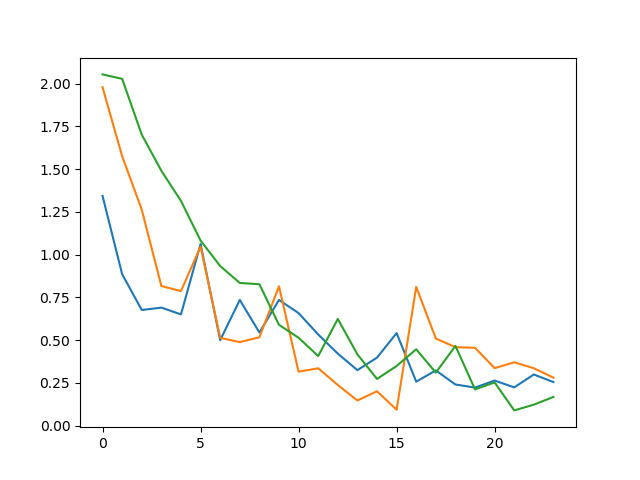

In [191]:
plt.plot(list(range(0,len(all_losses_40_1))),all_losses_40_1)
plt.plot(list(range(0,len(all_losses_40_2))),all_losses_40_2)
plt.plot(list(range(0,len(all_losses_40_3))),all_losses_40_3)
plt.show()